In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

Load Fashion_MNIST database

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Plot random image samples

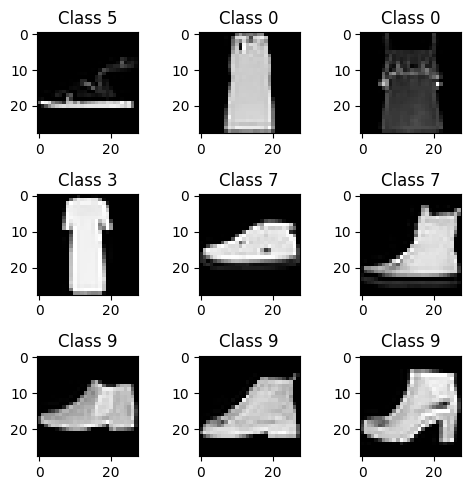

In [3]:
plt.rcParams['figure.figsize'] = (5,5)

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

Data pre-processing

In [4]:
num_class = 10
X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize the input
X_test /= 255

X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1)

y_train = to_categorical(y_train, num_class)
y_test = to_categorical(y_test, num_class)

Model definition the baseline model

In [5]:
model = Sequential()      
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape = (28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100, activation = "relu"))
model.add(Dense(num_class, activation="softmax"))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

Configure and train the baseline model

In [7]:
opt = Adam(lr=0.002)
model.compile(loss="categorical_crossentropy", optimizer = opt, metrics=["accuracy"])

In [8]:
model.fit(X_train, y_train, batch_size=128, epochs=15)

Epoch 1/15
469/469 [==============================] - 54s 112ms/step - loss: 0.6048 - accuracy: 0.7789
Epoch 2/15
469/469 [==============================] - 53s 112ms/step - loss: 0.4070 - accuracy: 0.8529
Epoch 3/15
469/469 [==============================] - 52s 110ms/step - loss: 0.3551 - accuracy: 0.8720
Epoch 4/15
469/469 [==============================] - 52s 111ms/step - loss: 0.3223 - accuracy: 0.8826
Epoch 5/15
469/469 [==============================] - 51s 109ms/step - loss: 0.3030 - accuracy: 0.8891
Epoch 6/15
469/469 [==============================] - 51s 108ms/step - loss: 0.2863 - accuracy: 0.8950
Epoch 7/15
469/469 [==============================] - 51s 108ms/step - loss: 0.2711 - accuracy: 0.8998
Epoch 8/15
469/469 [==============================] - 50s 107ms/step - loss: 0.2593 - accuracy: 0.9036
Epoch 9/15
469/469 [==============================] - 50s 107ms/step - loss: 0.2494 - accuracy: 0.9083
Epoch 10/15
469/469 [==============================] - 50s 107ms/step - l

Evaluate on test set

In [9]:
score = model.evaluate(X_test, y_test)
print('accuracy on test data:', score[1])

313/313 [==============================] - 3s 8ms/step - loss: 0.2315 - accuracy: 0.9145
accuracy on test data: 0.9144999980926514


Save the TF model

In [10]:
model.save('baseline_model.h5')

Load the model 

In [11]:
from tensorflow.keras.models import load_model
baseline_model = load_model('baseline_model.h5')

Convert it into an Equivalent TFLite model

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(baseline_model)
tflite_model = converter.convert()

Save the TFLite model in your workspace

In [13]:
import pathlib

tflite_models_dir = pathlib.Path("/content/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"model.tflite"
tflite_model_file.write_bytes(tflite_model)

723104

You can also export a TensorFlow model as a concrete function

In [14]:
# export model as  a concrete function
func = tf.function(baseline_model).get_concrete_function(
    tf.TensorSpec(baseline_model.inputs[0].shape, baseline_model.inputs[0].dtype))
# serialized graph representation of the concrte function
func.graph.as_graph_def()
# converting the concrete function to TfLite 
converter =  tf.lite.TFLiteConverter.from_concrete_functions([func])
tflite_model = converter.convert()

Prediction on the test set using the TFLite model

In [15]:
tflite_model_file = 'tflite_models/model.tflite'          
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

pred_list = []
for images in X_test:
  input_data = np.array(images, dtype=np.float32)

  input_data = input_data.reshape(1, input_data.shape[0], input_data.shape[1], 1)

  interpreter.set_tensor(input_index, input_data)
  interpreter.invoke()
  prediction = interpreter.get_tensor(output_index)
  prediction = np.argmax(prediction)
  pred_list.append(prediction)

accurate_count = 0
for index in range(len(pred_list)):
  if pred_list[index] == np.argmax(y_test[index]):
      accurate_count += 1
accuracy = accurate_count * 1.0 / len(pred_list)

print('accuracy = ', accuracy)

accuracy =  0.9145


Post training quantization

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(baseline_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_ptq = converter.convert()

Save the model after post-training quantization

In [17]:
tflite_models_dir = pathlib.Path("/content/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"model_ptq.tflite"
tflite_model_file.write_bytes(tflite_model_ptq)

188672

Evaluate the model performance 

In [18]:
tflite_model_file = 'tflite_models/model_ptq.tflite'          
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

pred_list = []
for images in X_test:
  input_data = np.array(images, dtype=np.float32)

  input_data = input_data.reshape(1, input_data.shape[0], input_data.shape[1], 1)

  interpreter.set_tensor(input_index, input_data)
  interpreter.invoke()
  prediction = interpreter.get_tensor(output_index)
  prediction = np.argmax(prediction)
  pred_list.append(prediction)

accurate_count = 0
for index in range(len(pred_list)):
  if pred_list[index] == np.argmax(y_test[index]):
      accurate_count += 1
accuracy = accurate_count * 1.0 / len(pred_list)

print(accuracy)

0.915


Install the package for TensorFlow Model Optimization

In [19]:
 pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 46.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.2 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.


Quantization aware training

In [20]:
import tensorflow_model_optimization as tfmot

baseline_model = load_model('baseline_model.h5')

quantized_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantized_model(baseline_model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28, 1)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 26, 26, 32)       387       
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 13, 13, 32)       1         
 zeWrapperV2)                                                    
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 11, 11, 64)       18627     
 pperV2)                                                         
                                                                 
 quant_max_pooling2d_1 (Quan  (None, 5, 5, 64)         1

Require a retraining

In [21]:
q_aware_model.fit(X_train, y_train,
                  batch_size=500, epochs=2, validation_split=0.1)

Epoch 1/2


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


108/108 [==============================] - 80s 691ms/step - loss: 0.2002 - accuracy: 0.9269 - val_loss: 0.1540 - val_accuracy: 0.9445
Epoch 2/2
108/108 [==============================] - 62s 577ms/step - loss: 0.1857 - accuracy: 0.9297 - val_loss: 0.1525 - val_accuracy: 0.9447


Convert and save the model as a TFLite file

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_qat = converter.convert()

tflite_models_dir = pathlib.Path("/content/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"model_qat.tflite"
tflite_model_file.write_bytes(tflite_model_qat)

/usr/local/lib/python3.9/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


187792

Evalaute on the test set

In [23]:
tflite_model_file = 'tflite_models/model_qat.tflite'          
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

pred_list = []
for images in X_test:
  input_data = np.array(images, dtype=np.float32)

  input_data = input_data.reshape(1, input_data.shape[0], input_data.shape[1], 1)

  interpreter.set_tensor(input_index, input_data)
  interpreter.invoke()
  prediction = interpreter.get_tensor(output_index)
  prediction = np.argmax(prediction)
  pred_list.append(prediction)

accurate_count = 0
for index in range(len(pred_list)):
  if pred_list[index] == np.argmax(y_test[index]):
      accurate_count += 1
accuracy = accurate_count * 1.0 / len(pred_list)

print('accuracy = ', accuracy)

accuracy =  0.9203


Selective quantization only on dense layers

In [24]:
baseline_model = load_model('baseline_model.h5')

def apply_quantization(layer):
      if isinstance(layer, tf.keras.layers.Dense):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
      return layer
annotated_model = tf.keras.models.clone_model(baseline_model,clone_function=apply_quantization,)
q_aware_model_dense = tfmot.quantization.keras.quantize_apply(annotated_model)
q_aware_model_dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 quant_dropout (QuantizeWrap  (None, 1600)             1

In [25]:
q_aware_model_dense.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model_dense.fit(X_train, y_train,
                  batch_size=500, epochs=2, validation_split=0.1)

Epoch 1/2


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


108/108 [==============================] - 49s 435ms/step - loss: 0.1963 - accuracy: 0.9267 - val_loss: 0.1538 - val_accuracy: 0.9445
Epoch 2/2
108/108 [==============================] - 48s 446ms/step - loss: 0.1853 - accuracy: 0.9316 - val_loss: 0.1541 - val_accuracy: 0.9438


Weight pruning based optimization

In [26]:
baseline_model = load_model('baseline_model.h5')

Apply a pruning scheduler

In [27]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_samples = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_samples / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.40,
                                                               final_sparsity=0.75,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(baseline_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 26, 26, 32)       610       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_max_poo  (None, 13, 13, 32)       1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 11, 11, 64)       36930     
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 5, 5, 64)         1         
 ling2d_1 (PruneLowMagnitude                                     
 )                                                               
                                                        

Train the model

In [28]:
import tempfile


log_dir = tempfile.mkdtemp()
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir)
]

model_for_pruning.fit(X_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/2
422/422 [==============================] - 52s 114ms/step - loss: 0.2569 - accuracy: 0.9038 - val_loss: 0.2485 - val_accuracy: 0.9075
Epoch 2/2
422/422 [==============================] - 46s 109ms/step - loss: 0.2950 - accuracy: 0.8915 - val_loss: 0.2379 - val_accuracy: 0.9112


Export and save the model

In [30]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
tflite_model_pruned = converter.convert()

import pathlib
tflite_models_dir = pathlib.Path("/content/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"model_pruned.tflite"
tflite_model_file.write_bytes(tflite_model_pruned)


723104

Evaluate on the test set

In [31]:
tflite_model_file = 'tflite_models/model_pruned.tflite'          
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

pred_list = []
for images in X_test:
  input_data = np.array(images, dtype=np.float32)

  input_data = input_data.reshape(1, input_data.shape[0], input_data.shape[1], 1)

  interpreter.set_tensor(input_index, input_data)
  interpreter.invoke()
  prediction = interpreter.get_tensor(output_index)
  prediction = np.argmax(prediction)
  pred_list.append(prediction)

accurate_count = 0
for index in range(len(pred_list)):
  if pred_list[index] == np.argmax(y_test[index]):
      accurate_count += 1
accuracy = accurate_count * 1.0 / len(pred_list)

print(accuracy)

0.8966


Save model file in a compressed zip format

In [32]:
def get_gzipped_model(file):
  import os
  import zipfile
  import tempfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

print("Size of compresssed baseline model: %.2f bytes" % (get_gzipped_model('tflite_models/model.tflite')))

print("Size of zipped pruned TFlite model: %.2f bytes" % (get_gzipped_model('tflite_models/model_pruned.tflite')))


Size of compresssed baseline model: 670637.00 bytes
Size of zipped pruned TFlite model: 246983.00 bytes


Selective pruning only to the dense layers

In [33]:
baseline_model = load_model('baseline_model.h5')
def apply_pruning(layer):
  if isinstance(layer, tf.keras.layers.Dense):
    return tfmot.sparsity.keras.prune_low_magnitude(layer)
  return layer

model_for_pruning = tf.keras.models.clone_model(
    baseline_model,
    clone_function=apply_pruning)

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [34]:
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

log_dir = tempfile.mkdtemp()
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir)
]

model_for_pruning.fit(X_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/2


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


422/422 [==============================] - 50s 114ms/step - loss: 0.2077 - accuracy: 0.9224 - val_loss: 0.1716 - val_accuracy: 0.9402
Epoch 2/2
422/422 [==============================] - 48s 113ms/step - loss: 0.1969 - accuracy: 0.9265 - val_loss: 0.1665 - val_accuracy: 0.9365


In [35]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
tflite_model_pruned_dense = converter.convert()

tflite_models_dir = pathlib.Path("/content/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"model_pruned_dense.tflite"
tflite_model_file.write_bytes(tflite_model_pruned_dense)

723104

Check compressed model size

In [36]:
print("Size of compresssed baseline model: %.2f bytes" % (get_gzipped_model('tflite_models/model.tflite')))

print("Size of zipped pruned TFlite model: %.2f bytes" % (get_gzipped_model('tflite_models/model_pruned.tflite')))

print("Size of zipped pruned TFlite model only dense layers: %.2f bytes" % (get_gzipped_model('tflite_models/model_pruned_dense.tflite')))

Size of compresssed baseline model: 670637.00 bytes
Size of zipped pruned TFlite model: 246983.00 bytes
Size of zipped pruned TFlite model only dense layers: 439924.00 bytes


Check the model performance where only the dense layers are pruned

In [37]:
tflite_model_file = 'tflite_models/model_pruned_dense.tflite'          
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

pred_list = []
for images in X_test:
  input_data = np.array(images, dtype=np.float32)

  input_data = input_data.reshape(1, input_data.shape[0], input_data.shape[1], 1)

  interpreter.set_tensor(input_index, input_data)
  interpreter.invoke()
  prediction = interpreter.get_tensor(output_index)
  prediction = np.argmax(prediction)
  pred_list.append(prediction)

accurate_count = 0
for index in range(len(pred_list)):
  if pred_list[index] == np.argmax(y_test[index]):
      accurate_count += 1
accuracy = accurate_count * 1.0 / len(pred_list)

print('accuracy = ', accuracy)

accuracy =  0.917


Optimization using weight clustering

In [38]:
baseline_model = load_model('baseline_model.h5')

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 16,
  'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS
}

# Cluster a whole model
clustered_model = cluster_weights(baseline_model, **clustering_params)

# Use smaller learning rate for fine-tuning clustered model
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

clustered_model.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  optimizer=opt,
  metrics=['accuracy'])

clustered_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d (ClusterWeig  (None, 26, 26, 32)       624       
 hts)                                                            
                                                                 
 cluster_max_pooling2d (Clus  (None, 13, 13, 32)       0         
 terWeights)                                                     
                                                                 
 cluster_conv2d_1 (ClusterWe  (None, 11, 11, 64)       36944     
 ights)                                                          
                                                                 
 cluster_max_pooling2d_1 (Cl  (None, 5, 5, 64)         0         
 usterWeights)                                                   
                                                                 
 cluster_flatten (ClusterWei  (None, 1600)             0

Train the model

In [39]:
# Fine-tune model
clustered_model.fit(
  X_train,
  y_train,
  batch_size=128,
  epochs=2,
  validation_split=0.1)

Epoch 1/2


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


422/422 [==============================] - 70s 162ms/step - loss: 0.1654 - accuracy: 0.9396 - val_loss: 0.1581 - val_accuracy: 0.9420
Epoch 2/2
422/422 [==============================] - 57s 135ms/step - loss: 0.1570 - accuracy: 0.9428 - val_loss: 0.1576 - val_accuracy: 0.9395


Save the model

In [40]:
model_for_export = tfmot.clustering.keras.strip_clustering(clustered_model)

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
tflite_model_clustered = converter.convert()

tflite_models_dir = pathlib.Path("/content/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"model_clustered.tflite"
tflite_model_file.write_bytes(tflite_model_clustered)

723104

Evaluate model performance

In [41]:
tflite_model_file = 'tflite_models/model_clustered.tflite'          
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

pred_list = []
for images in X_test:
  input_data = np.array(images, dtype=np.float32)

  input_data = input_data.reshape(1, input_data.shape[0], input_data.shape[1], 1)

  interpreter.set_tensor(input_index, input_data)
  interpreter.invoke()
  prediction = interpreter.get_tensor(output_index)
  prediction = np.argmax(prediction)
  pred_list.append(prediction)

accurate_count = 0
for index in range(len(pred_list)):
  if pred_list[index] == np.argmax(y_test[index]):
      accurate_count += 1
accuracy = accurate_count * 1.0 / len(pred_list)

print(accuracy)

0.9124


Size of compresded model after clustering

In [42]:
print("Size of zipped clustered TFlite model: %.2f bytes" % (get_gzipped_model('tflite_models/model_clustered.tflite')))

Size of zipped clustered TFlite model: 125798.00 bytes


Selective clustering on dense layers

In [43]:
baseline_model = load_model('baseline_model.h5')

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 3,
  'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS
}

def apply_clustering(layer):
  if isinstance(layer, tf.keras.layers.Dense):
    return cluster_weights(layer, **clustering_params)
  return layer

clustered_model = tf.keras.models.clone_model(
    baseline_model,
    clone_function=apply_clustering,
)

clustered_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

Collaborative Quantization

Sparsity preserving clustering


Firt apply weight pruning and retrain

In [45]:
import tensorflow_model_optimization as tfmot

baseline_model = load_model('baseline_model.h5')

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
  }

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

pruned_model = prune_low_magnitude(baseline_model, **pruning_params)
pruned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 26, 26, 32)       610       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_max_poo  (None, 13, 13, 32)       1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 11, 11, 64)       36930     
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 5, 5, 64)         1         
 ling2d_1 (PruneLowMagnitude                                     
 )                                                               
                                                        

In [46]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

pruned_model.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  optimizer=opt,
  metrics=['accuracy'])

pruned_model.summary()

pruned_model.fit(X_train, y_train, batch_size=128, epochs=3,validation_split=0.1, callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 26, 26, 32)       610       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_max_poo  (None, 13, 13, 32)       1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 11, 11, 64)       36930     
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 5, 5, 64)         1         
 ling2d_1 (PruneLowMagnitude                                     
 )                                                               
                                                        

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


422/422 [==============================] - 51s 114ms/step - loss: 0.3448 - accuracy: 0.8698 - val_loss: 0.2823 - val_accuracy: 0.8992
Epoch 2/3
422/422 [==============================] - 45s 107ms/step - loss: 0.3137 - accuracy: 0.8838 - val_loss: 0.2407 - val_accuracy: 0.9143
Epoch 3/3
422/422 [==============================] - 48s 113ms/step - loss: 0.2838 - accuracy: 0.8951 - val_loss: 0.2233 - val_accuracy: 0.9202


Export the pruned model

In [47]:
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

stripped_pruned_model_copy = tf.keras.models.clone_model(stripped_pruned_model)
stripped_pruned_model_copy.set_weights(stripped_pruned_model.get_weights())

Sparsity preserving clustering

In [48]:
from tensorflow_model_optimization.python.core.clustering.keras.experimental import (
    cluster,
)

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization.KMEANS_PLUS_PLUS

cluster_weights = cluster.cluster_weights

clustering_params = {
  'number_of_clusters': 8,
  'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS,
  'preserve_sparsity': True
}

sparsity_clustered_model = cluster_weights(stripped_pruned_model_copy, **clustering_params)

sparsity_clustered_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

sparsity_clustered_model.fit(X_train, y_train, batch_size=128, epochs=3, validation_split=0.1)

Epoch 1/3
422/422 [==============================] - 63s 144ms/step - loss: 0.1847 - accuracy: 0.9310 - val_loss: 0.1712 - val_accuracy: 0.9355
Epoch 2/3
422/422 [==============================] - 55s 130ms/step - loss: 0.1641 - accuracy: 0.9381 - val_loss: 0.1864 - val_accuracy: 0.9328
Epoch 3/3
422/422 [==============================] - 56s 132ms/step - loss: 0.1574 - accuracy: 0.9401 - val_loss: 0.1732 - val_accuracy: 0.9315


Save with post training quantization

In [49]:
stripped_sparsity_clustered_model = tfmot.clustering.keras.strip_clustering(sparsity_clustered_model)

converter = tf.lite.TFLiteConverter.from_keras_model(stripped_sparsity_clustered_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
sparsity_clustered_quant_model = converter.convert()

import pathlib
tflite_models_dir = pathlib.Path("/content/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"model_sparsity_clustered_qunat.tflite"
tflite_model_file.write_bytes(sparsity_clustered_quant_model)



188672

Evaluate the model performance

In [50]:
tflite_model_file = 'tflite_models/model_sparsity_clustered_qunat.tflite'          
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

pred_list = []
for images in X_test:
  input_data = np.array(images, dtype=np.float32)

  input_data = input_data.reshape(1, input_data.shape[0], input_data.shape[1], 1)

  interpreter.set_tensor(input_index, input_data)
  interpreter.invoke()
  prediction = interpreter.get_tensor(output_index)
  prediction = np.argmax(prediction)
  pred_list.append(prediction)

accurate_count = 0
for index in range(len(pred_list)):
  if pred_list[index] == np.argmax(y_test[index]):
      accurate_count += 1
accuracy = accurate_count * 1.0 / len(pred_list)

print(accuracy)

0.9112


Check the compressed model size

In [51]:
def get_gzipped_model(file):
  import os
  import zipfile
  import tempfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [52]:
print("Size of zipped sparsity preserved clustered TFlite model: %.2f bytes" % (get_gzipped_model('tflite_models/model_sparsity_clustered_qunat.tflite')))

Size of zipped sparsity preserved clustered TFlite model: 61264.00 bytes
